In [1]:
#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

### EDA

In [2]:
df= pd.read_csv("store item demand train.csv")
df.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [3]:
df.tail(5)

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [4]:
df.shape

(913000, 4)

In [5]:
df.describe(include="all")

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
unique,1826,NaN,NaN,NaN
top,2015-05-31,NaN,NaN,NaN
freq,500,NaN,NaN,NaN
mean,NaN,5.500000,25.500000,52.250287
std,NaN,2.872283,14.430878,28.801144
min,NaN,1.000000,1.000000,0.000000
25%,NaN,3.000000,13.000000,30.000000
50%,NaN,5.500000,25.500000,47.000000
75%,NaN,8.000000,38.000000,70.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df.corr()

,store,item,sales
store,1.00000,0.000000,-0.008170
item,0.00000,1.000000,-0.055998
sales,-0.00817,-0.055998,1.000000


In [8]:
#converting Date from string to datetime
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

In [9]:
# Expand dataframe with more useful columns
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

df = expand_df(df)
display(df)

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,2
912996,2017-12-28,10,50,59,28,12,2017,3
912997,2017-12-29,10,50,74,29,12,2017,4
912998,2017-12-30,10,50,62,30,12,2017,5


In [10]:
df = df.set_index('date')
df.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


<AxesSubplot:xlabel='date', ylabel='sales'>

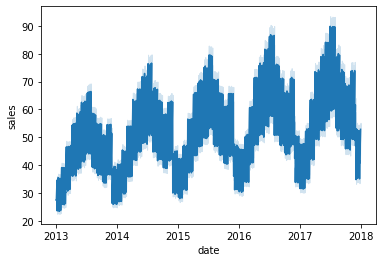

In [11]:
sns.lineplot(x="date",y="sales",size=None ,data=df )

# Decomposing Time Series


<Figure size 432x288 with 0 Axes>

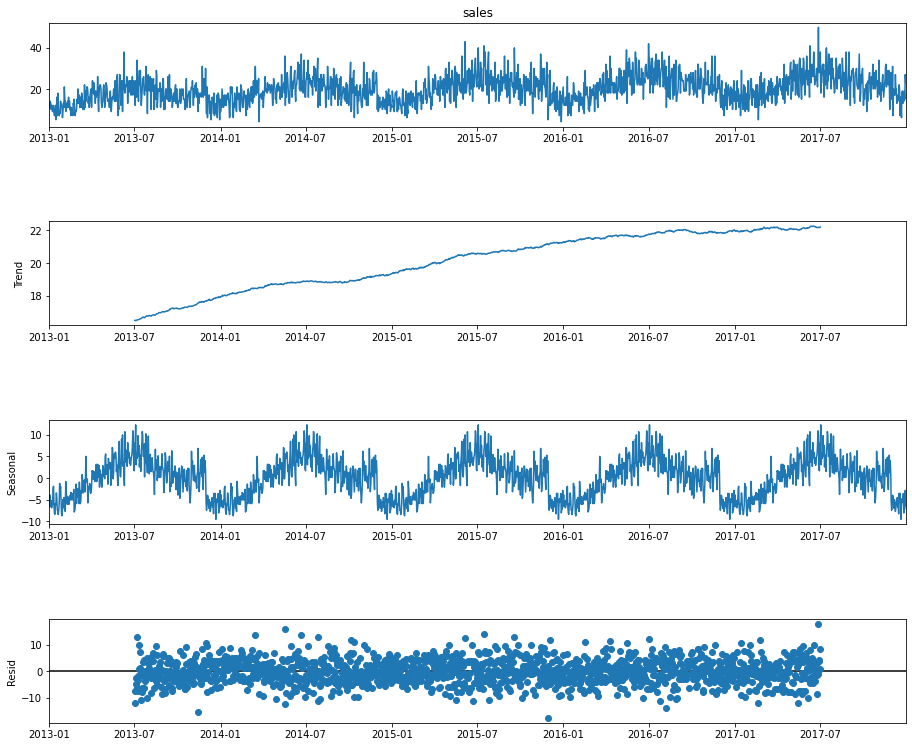

In [12]:
# Lets decompose for data of smaller size. Here I will take data having item and store equal to 1.

train_item1 = df[df['item']==1]
train_final = train_item1[train_item1['store']==1]

#from statsmodels.tsa.seasonal import seasonal_decompose
result = sm.tsa.seasonal_decompose(train_final['sales'], model='additive', freq=365) #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

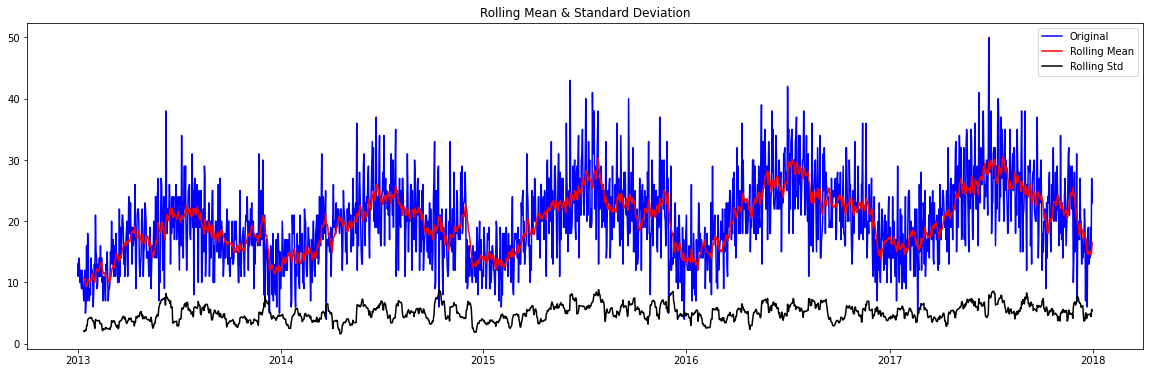

In [13]:
def roll_stats(timeseries, window = 12, cutoff = 0.01):
    
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
   # plt.rcParams['agg.path.chunksize'] = 50000
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
roll_stats(train_final['sales'])  


In [14]:
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(train_final['sales'])

p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


### making time series stationary

date
2013-01-02   -2.0
2013-01-03    3.0
2013-01-04   -1.0
2013-01-05   -3.0
2013-01-06    2.0
Name: sales, dtype: float64


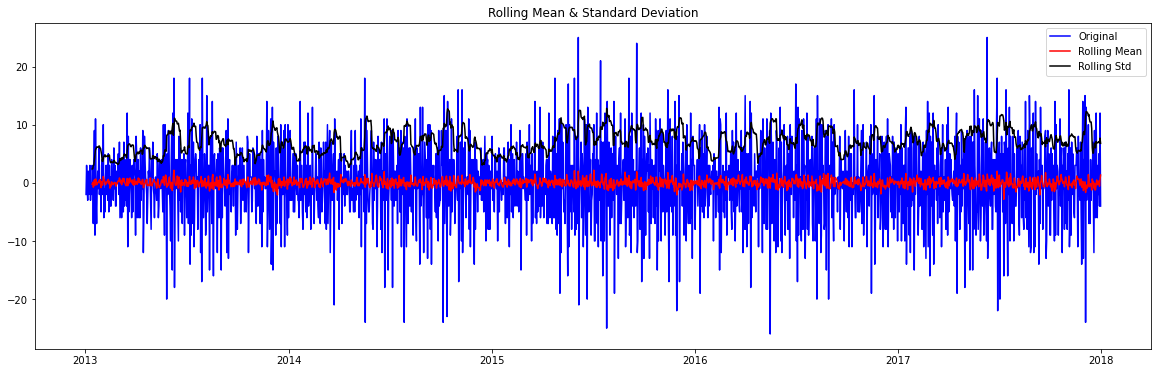

p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [15]:
first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())

roll_stats(first_diff,window = 12, cutoff = 0.01)
dickey_fuller_test(first_diff, window = 12)

## Now the time series is stationary
# Plot ACF/PACF charts and find optimal parameters:

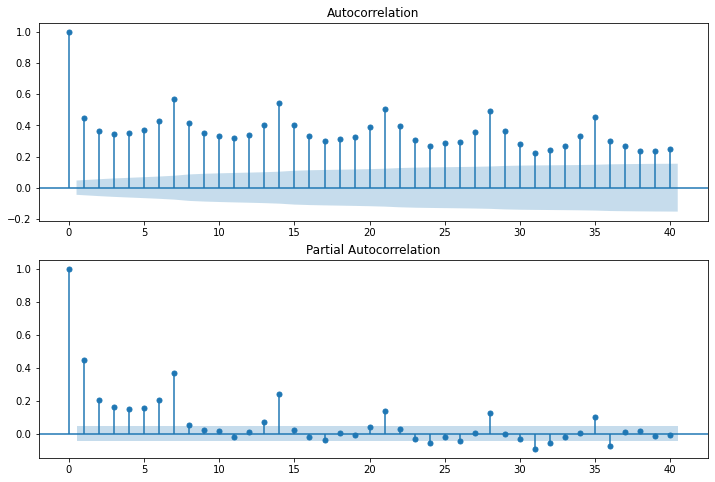

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_final.sales, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_final.sales, lags=40, ax=ax2)     # lags=40

after differencing

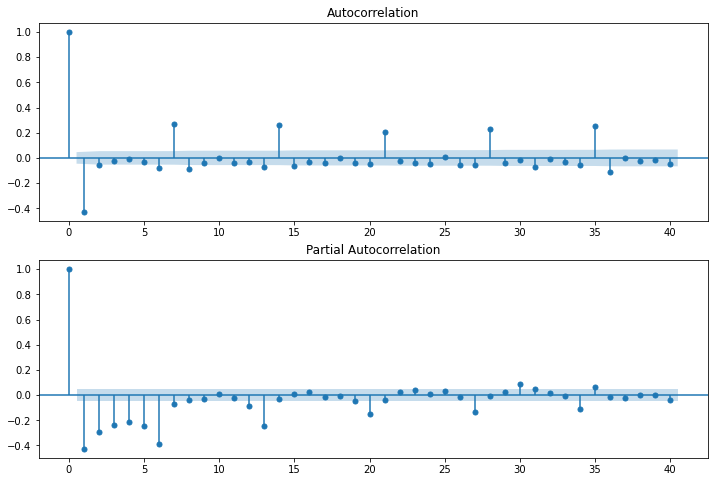

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists.
Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont

# Determining order p, d, q through ACF/PACF plots:
It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use AR = 6

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

### Order of the AR term (p)

In [18]:
arima_model = sm.tsa.ARIMA(train_final.sales, (6,1,0)).fit(disp=False)
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Sun, 16 Jan 2022   AIC                          11211.335
Time:                        15:58:53   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

Analyze the result
To see how our first model perform, we can plot the residual distribution. See if it's normal dist. And the ACF and PACF. For a good model, we want to see the residual is normal distribution. And ACF, PACF has not significant terms.

In [19]:
arima_model = sm.tsa.ARIMA(train_final.sales, (7,1,0)).fit(disp=False)
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -5593.136
Method:                       css-mle   S.D. of innovations              5.182
Date:                Sun, 16 Jan 2022   AIC                          11204.271
Time:                        15:59:35   BIC                          11253.856
Sample:                    01-02-2013   HQIC                         11222.562
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0038      0.024      0.162      0.872      -0.043       0.050
ar.L1.D.sales    -0.8449      0.023    -36.175      0.000      -0.891      -0.799
ar.L2.D.sales    -0.7868      0.029    -

In [20]:
arima_model = sm.tsa.ARIMA(train_final.sales, (6,1,1)).fit(disp=False)
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5592.108
Method:                       css-mle   S.D. of innovations              5.179
Date:                Sun, 16 Jan 2022   AIC                          11202.216
Time:                        15:59:57   BIC                          11251.800
Sample:                    01-02-2013   HQIC                         11220.507
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0038      0.023      0.166      0.868      -0.041       0.049
ar.L1.D.sales    -0.6344      0.059    -10.801      0.000      -0.750      -0.519
ar.L2.D.sales    -0.6173      0.047    -

NormaltestResult(statistic=14.314847576633543, pvalue=0.0007790589910555765)


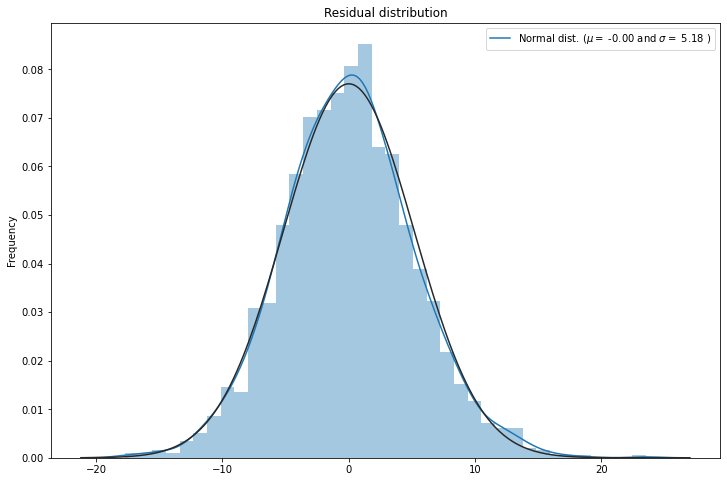

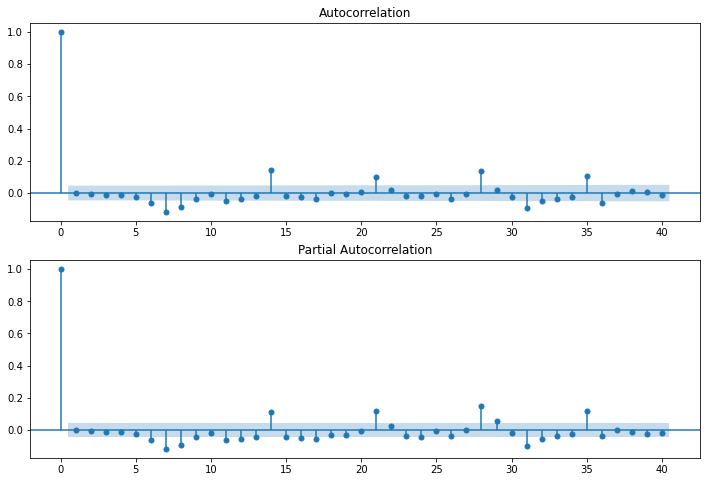

In [21]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_model.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_model.resid, lags=40, ax=ax2)

Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality.it means ar ma value is correct

# Prediction using ARIMA Model
Take the last 30 days in training set as validation data

<AxesSubplot:xlabel='date'>

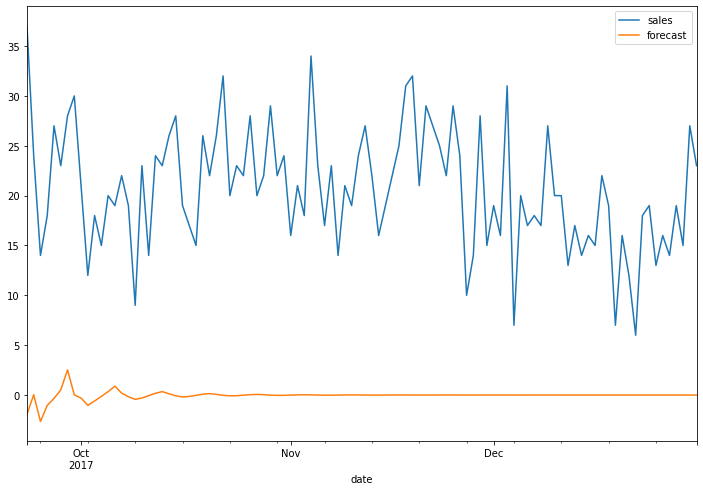

In [23]:
start_index = 1726
end_index = 1826
df['forecast'] = arima_model.predict(start = start_index, end= end_index, dynamic= True)  
df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

### Consider seasonality affect by SARIMA

In [24]:
# Now we will use SARIMAX

sarima_model = sm.tsa.statespace.SARIMAX(train_final.sales, trend='n', order=(6,1,0)).fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Sun, 16 Jan 2022   AIC                          11209.359
Time:                        16:02:30   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.742690154956748, pvalue=0.00023140408788517887)


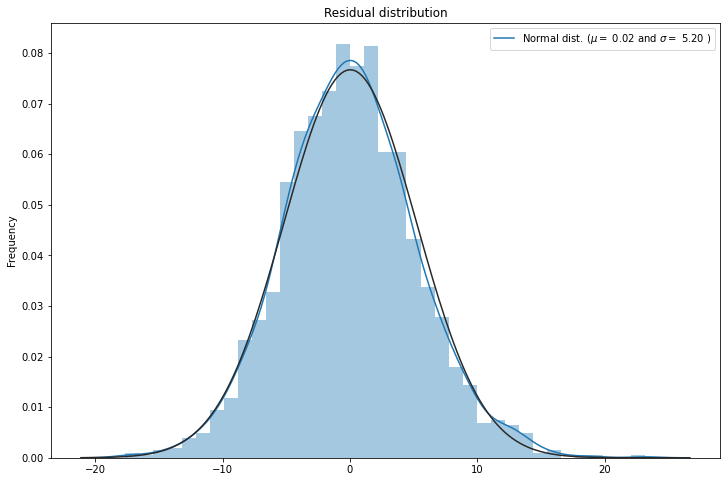

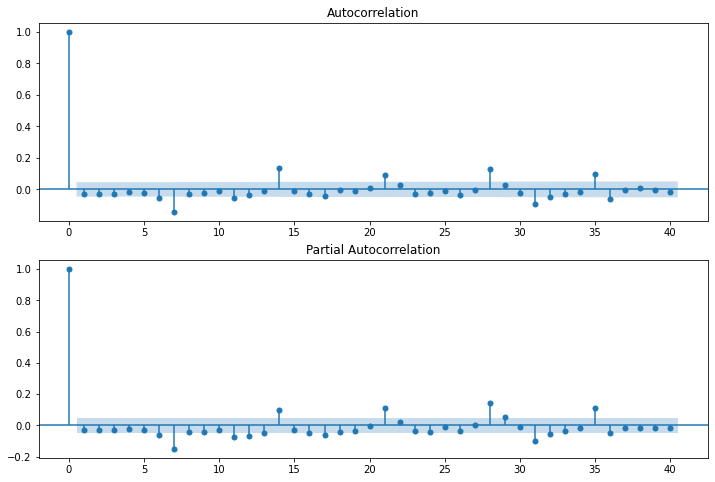

In [25]:
resid = sarima_model.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_model.resid, lags=40, ax=ax2)

## Prediction using SARIMA Model
Take the last 30 days in training set as validation data

<AxesSubplot:xlabel='date'>

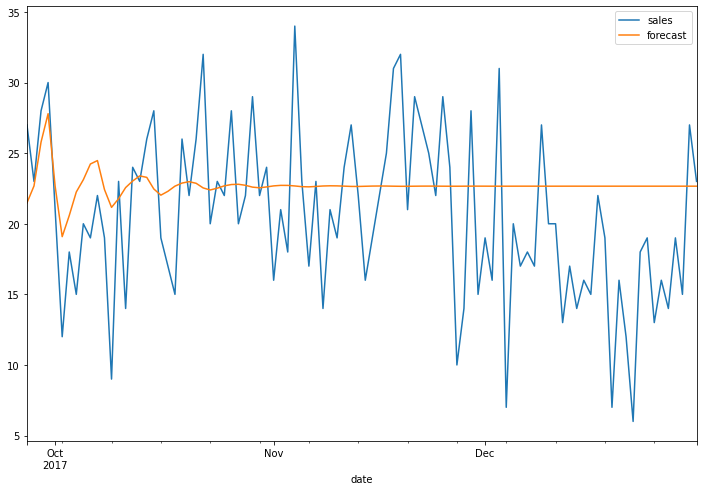

In [27]:
start_index = 1730
end_index = 1826
df['forecast'] = sarima_model.predict(start = start_index, end= end_index, dynamic= True)  
df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

We can see that this model is better than simple ARIMA model.

In [28]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [30]:
smape_kun(df[1730:1825]['sales'],df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %
